In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=7
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'AUSS.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
0,2016-12-31,5323,-2510,2813,-743,0,496,93,2658,-509,...,-2055,-2466,949,0,0,954,1903,6,311,203
1,2017-03-31,6075,-3149,2926,-771,0,-1845,106,416,-72,...,17,-248,-98,-4,0,-695,-796,-1,686,203
2,2017-06-30,5019,-2398,2621,-659,0,-169,24,1817,-419,...,158,-311,-81,-947,0,689,-338,-4,-384,203
3,2017-09-30,4903,-2438,2465,-707,0,-1447,18,329,-58,...,44,-413,-85,0,0,-147,-232,-9,553,203
4,2017-12-31,4800,-2504,2296,-767,0,-1947,57,-361,-180,...,66,-584,-569,446,0,165,41,5,474,203


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,11847,48062,2380,1153,1778,7879,5968,19899,561,-463
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,12177,50267,2164,1640,1734,8146,6061,20460,450,-471
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,12301,51933,2617,1249,1414,7556,9051,24871,926,-440
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,12265,52401,2950,2466,1290,8635,8939,26029,1086,-478
28,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,12265,52825,2671,1462,1255,8601,8850,25784,740,-578


## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,19899,561,-463,10.186402
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
28,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,19899,561,-463,10.186402
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
28,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [12]:

obj = yf.Ticker(share_name)
share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
share_price['real_date'] = share_price.index
# remove localization (timezone) to let merge the two columns
share_price['real_date'] = share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
share_price['share_price'] = share_price['Close']
share_price = share_price[['real_date', 'share_price']]

share_price.tail()

,real_date,share_price
Date,,
2024-01-29 00:00:00+01:00,2024-01-29,76.900002
2024-02-05 00:00:00+01:00,2024-02-05,76.150002
2024-02-12 00:00:00+01:00,2024-02-12,75.150002
2024-02-19 00:00:00+01:00,2024-02-19,74.400002
2024-02-26 00:00:00+01:00,2024-02-26,80.650002


## Merge the statement dataset with share prices

In [13]:
merged_nat_curr = pd.merge_asof(left=share_price, right=ratios_nat_curr, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nat_curr = merged_nat_curr.dropna()
merged_nat_curr = merged_nat_curr.reset_index(drop=True)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,57.423653,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,0.520357,0.479643,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.471971
1,2017-02-20,57.230953,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,0.520357,0.479643,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.471971
2,2017-02-27,55.882072,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,0.520357,0.479643,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.471971
3,2017-03-06,53.377022,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,0.520357,0.479643,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.471971
4,2017-03-13,53.762409,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,0.520357,0.479643,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.471971


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2017-02-13,57.423653,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,1.274273,0.528461,0.40372,0.245593,0.471971,1.356096,0.640037,0.547483,1.160060,2.276758
1,2017-02-20,57.230953,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,1.274273,0.528461,0.40372,0.245593,0.471971,1.351545,0.637890,0.545645,1.158223,2.269118
2,2017-02-27,55.882072,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,1.274273,0.528461,0.40372,0.245593,0.471971,1.319691,0.622855,0.532785,1.145363,2.215637
3,2017-03-06,53.377022,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,1.274273,0.528461,0.40372,0.245593,0.471971,1.260532,0.594934,0.508902,1.121479,2.116316
4,2017-03-13,53.762409,2016-12-31,5323.0,42.344828,89.719212,203.0,5120.0,25.221675,3745.0,...,1.274273,0.528461,0.40372,0.245593,0.471971,1.269633,0.599230,0.512576,1.125154,2.131596


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

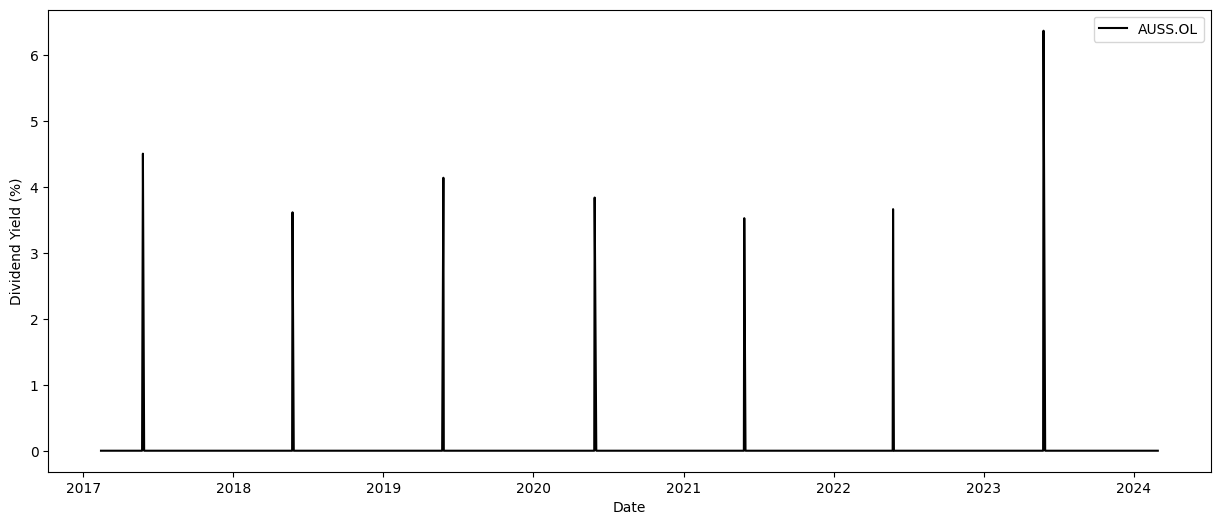

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.060649
share_price      1.000000
Name: share_price, dtype: float64


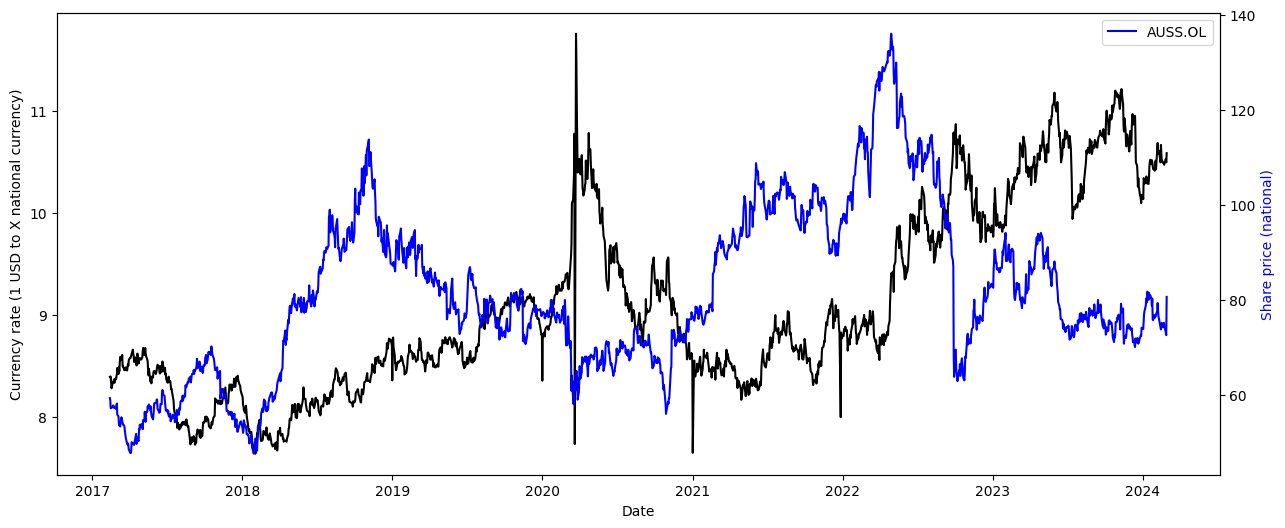

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

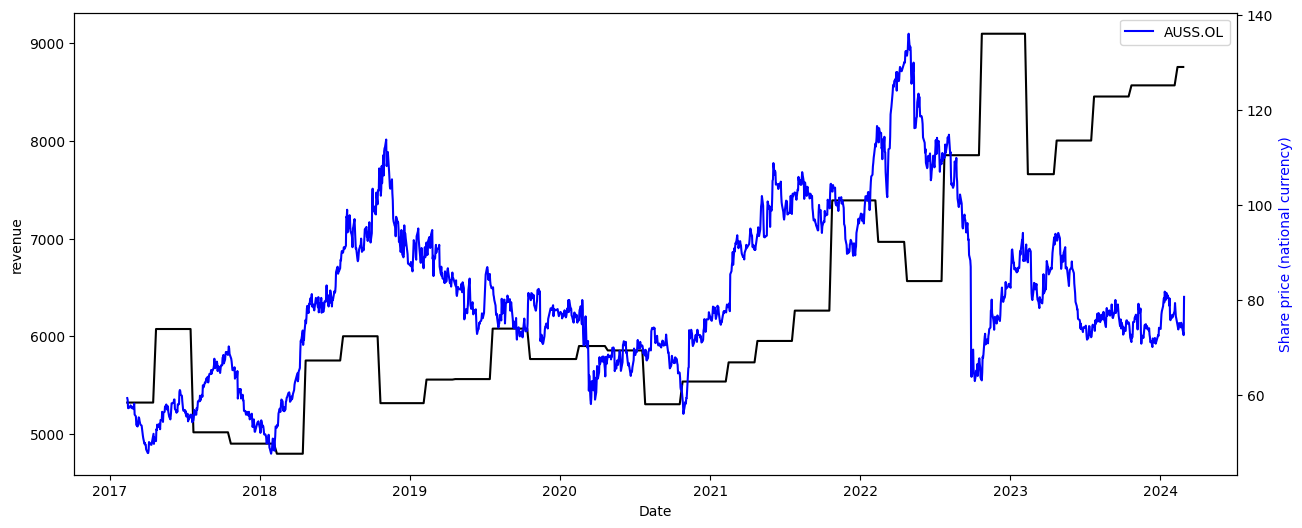

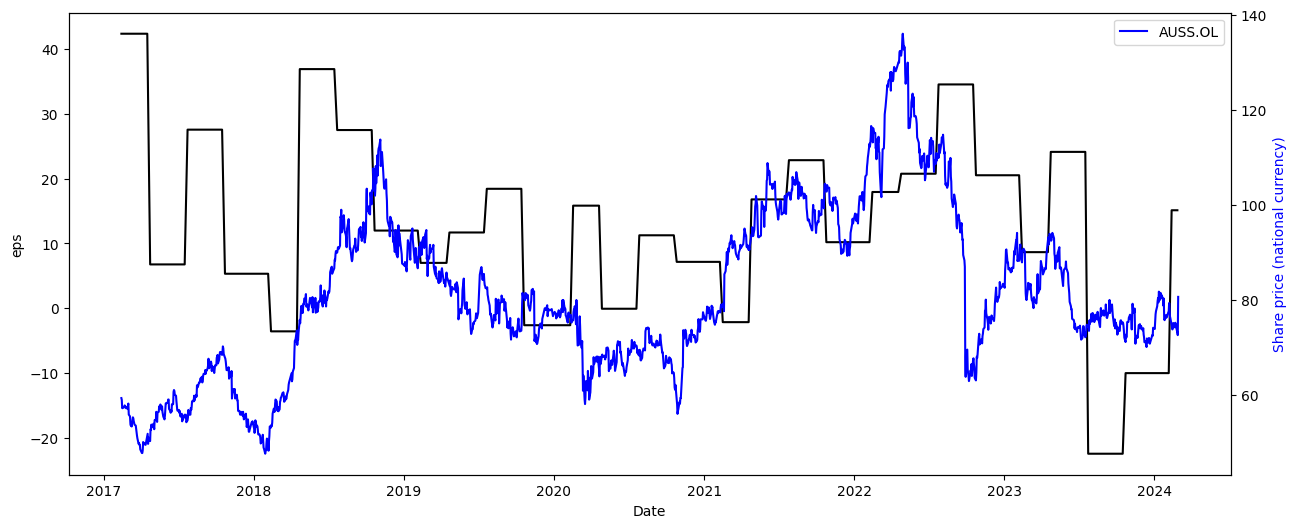

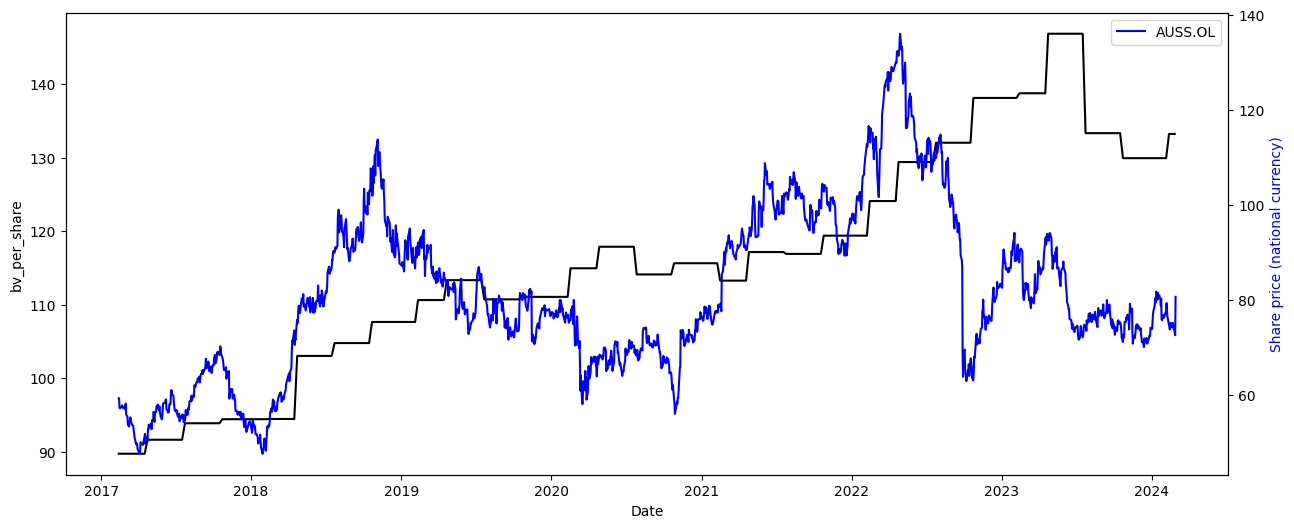

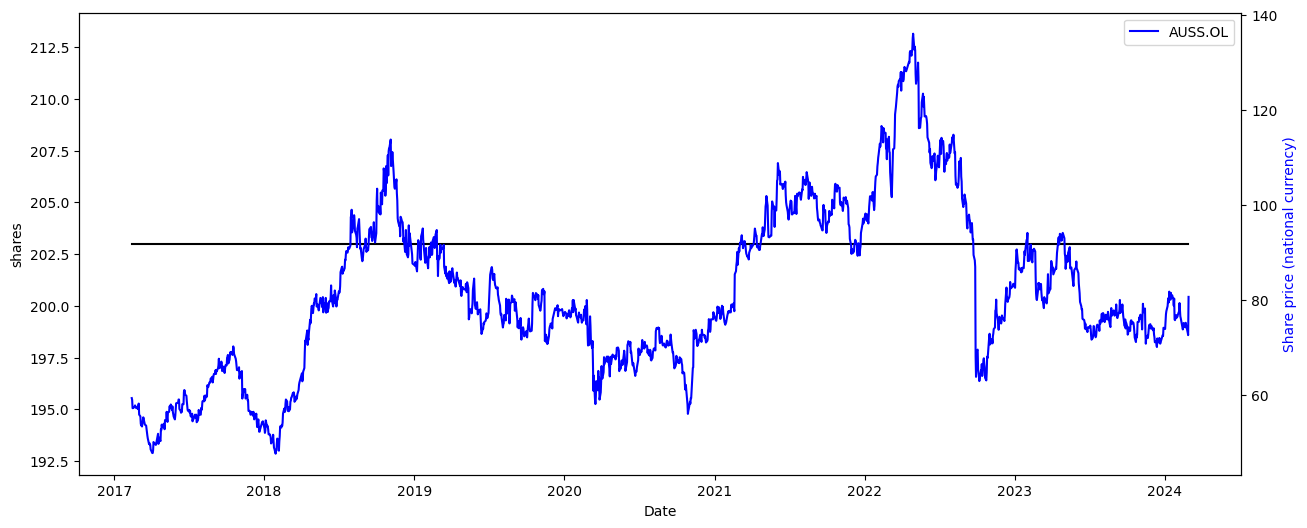

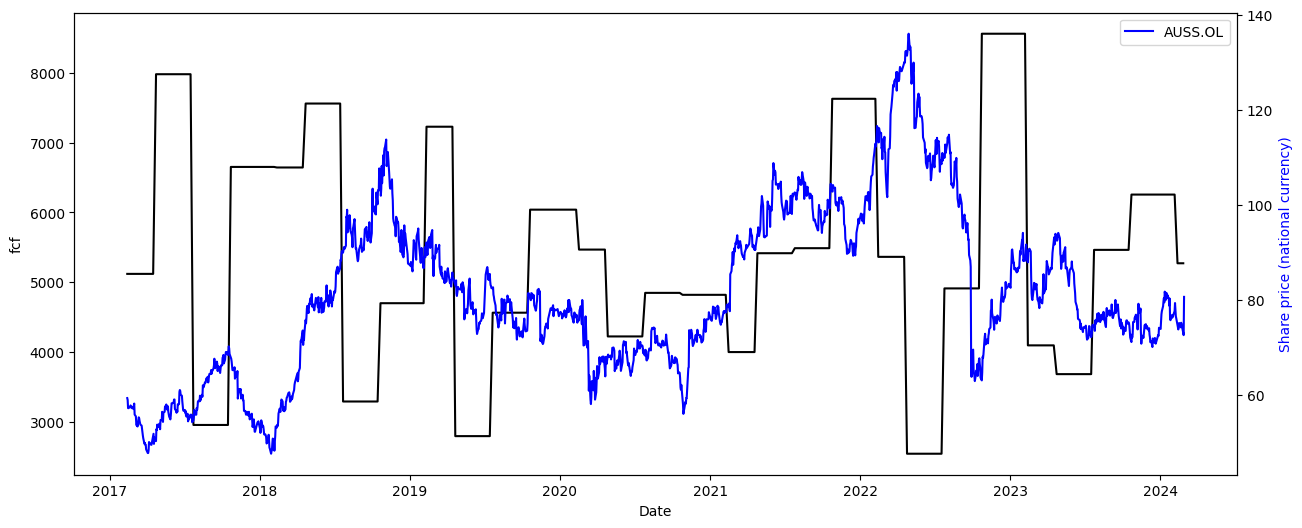

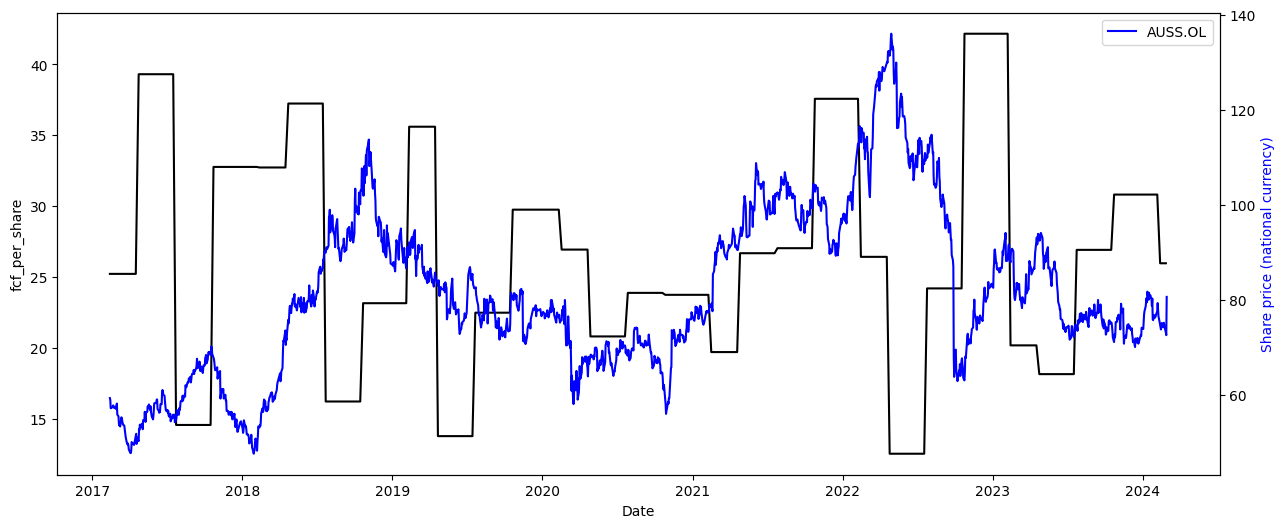

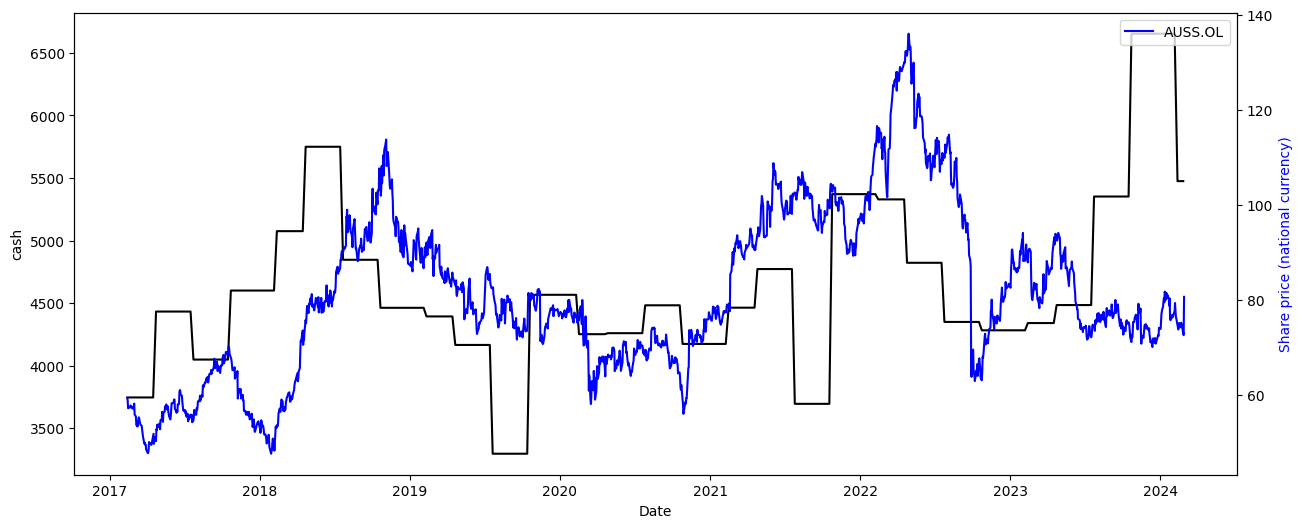

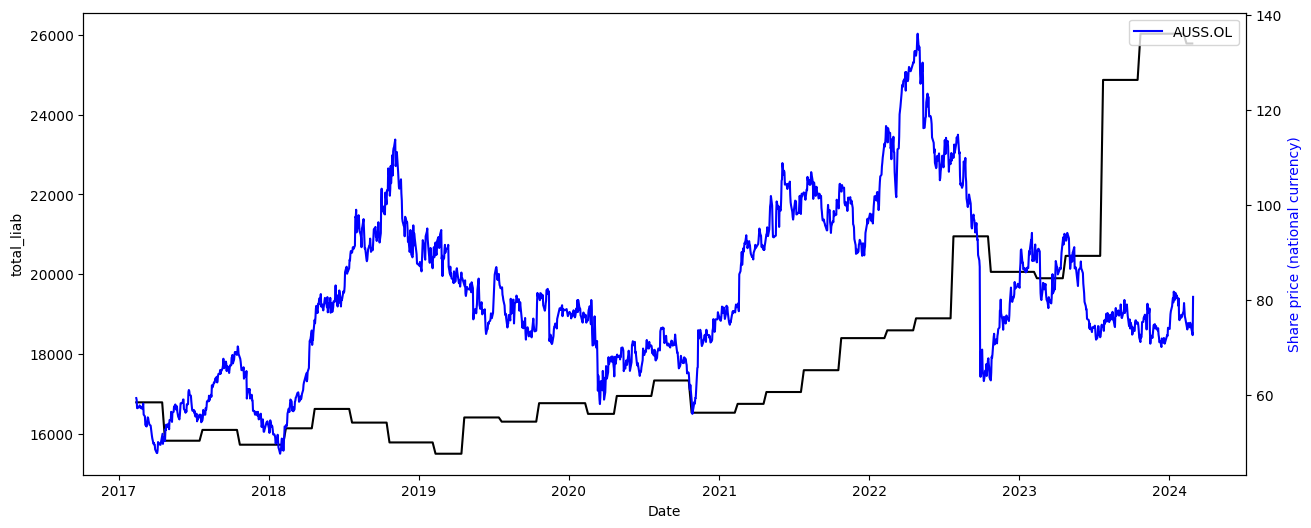

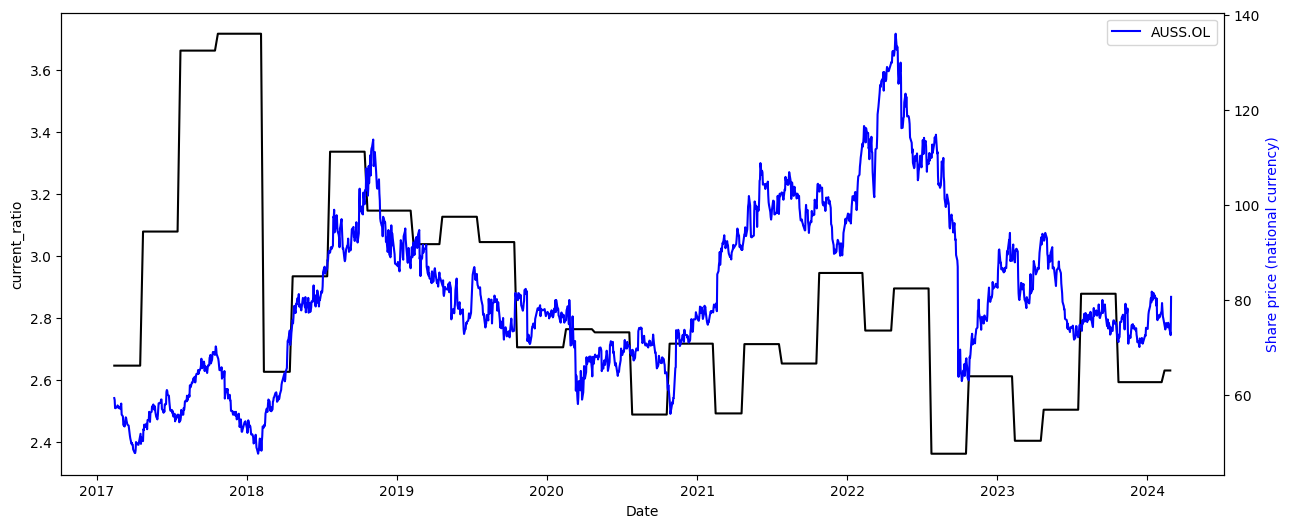

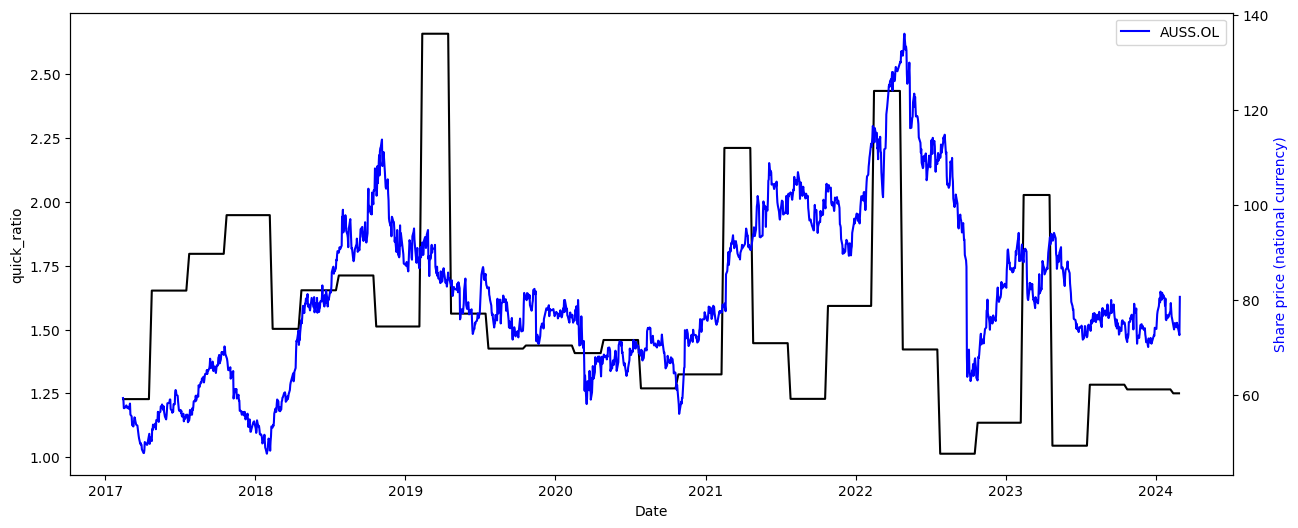

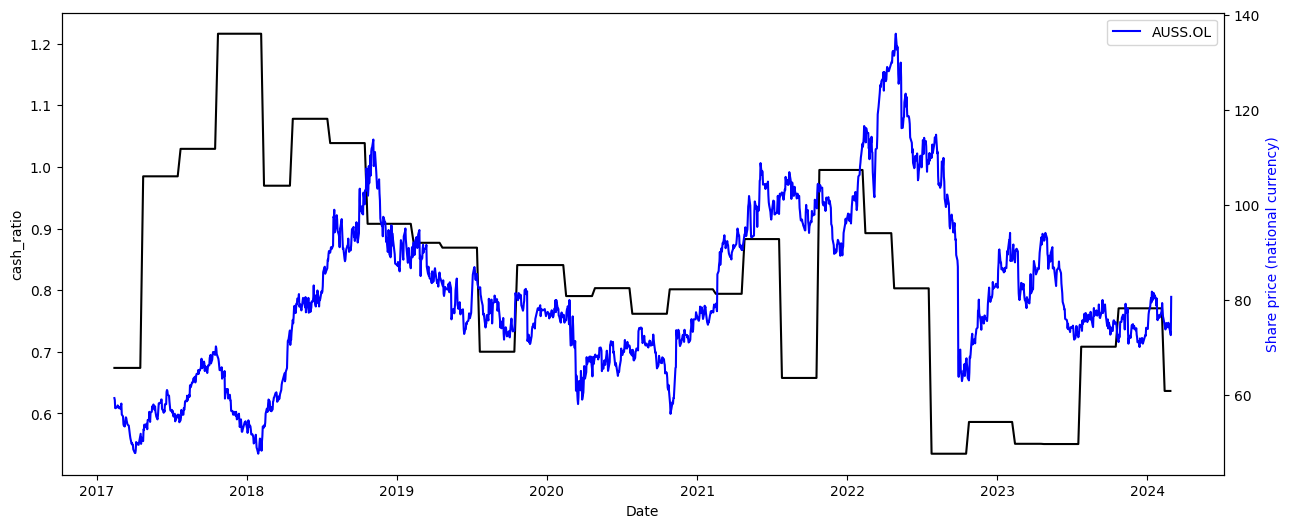

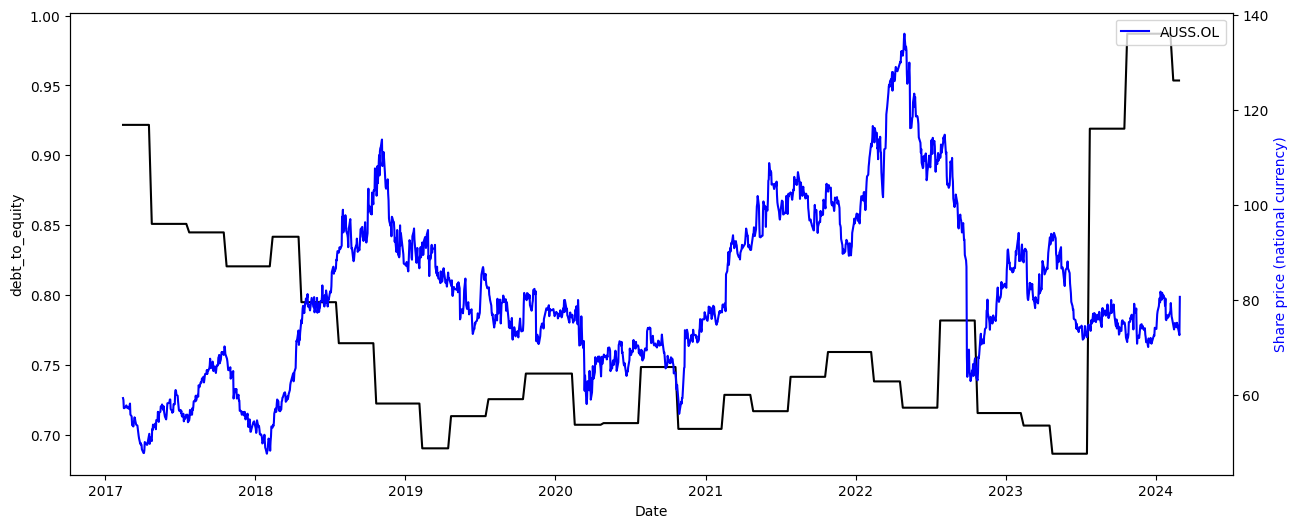

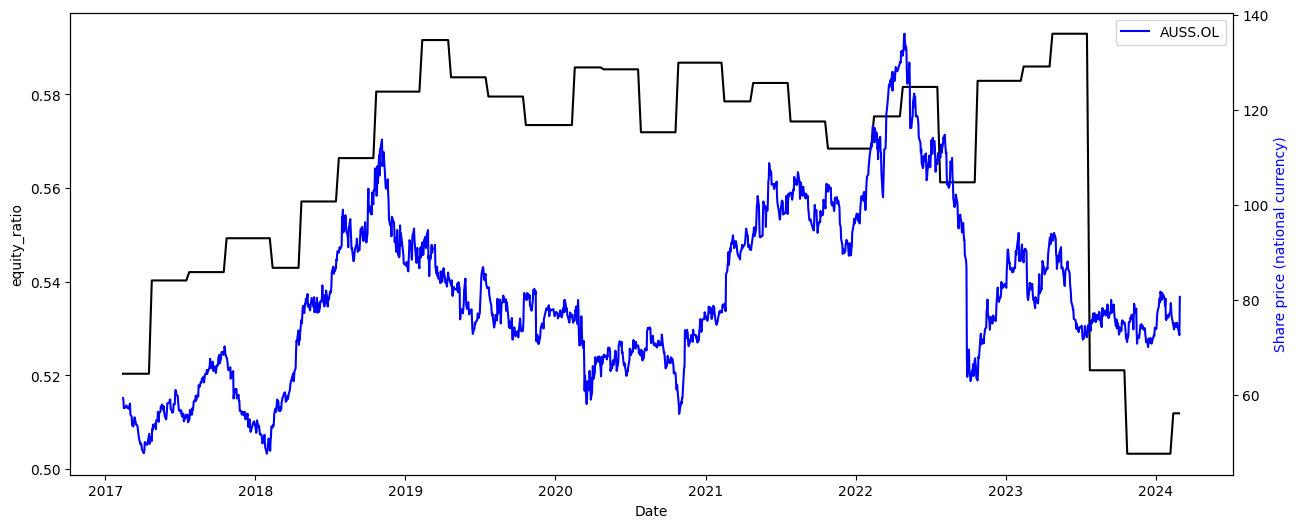

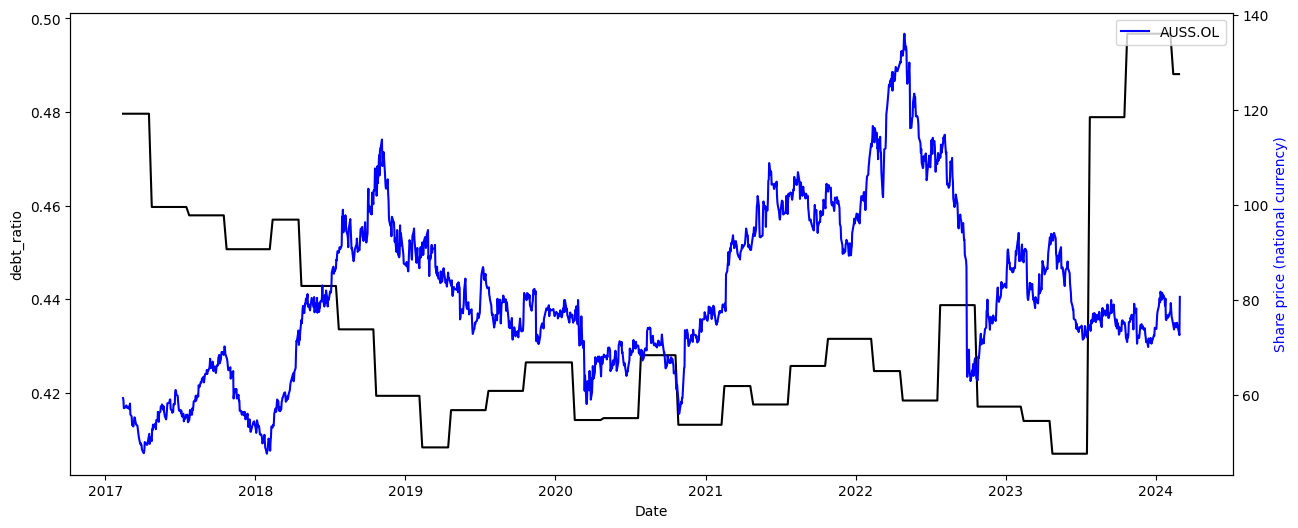

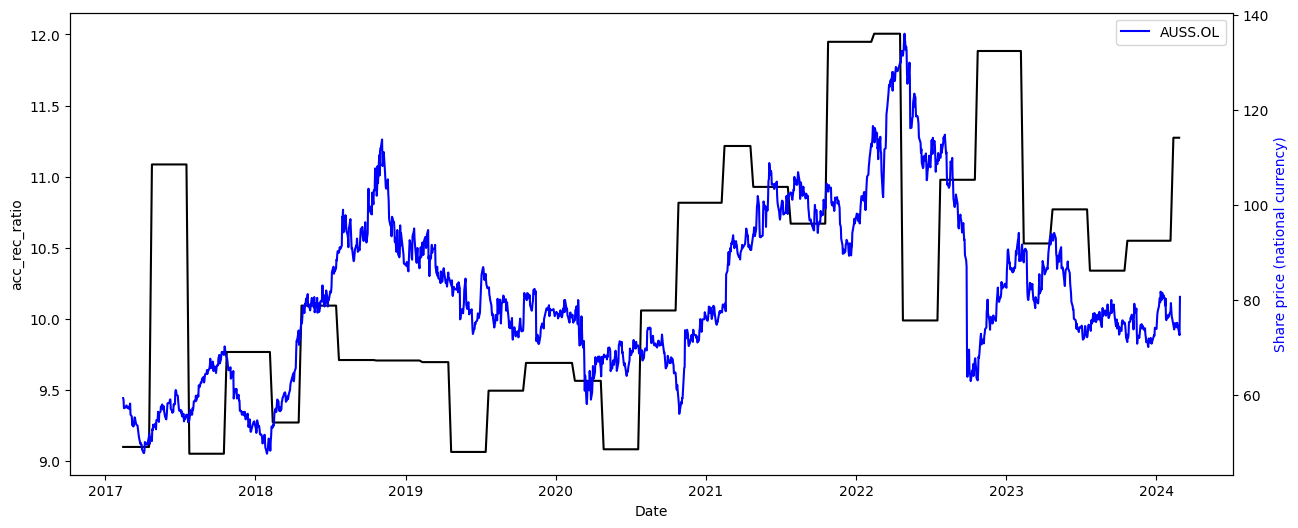

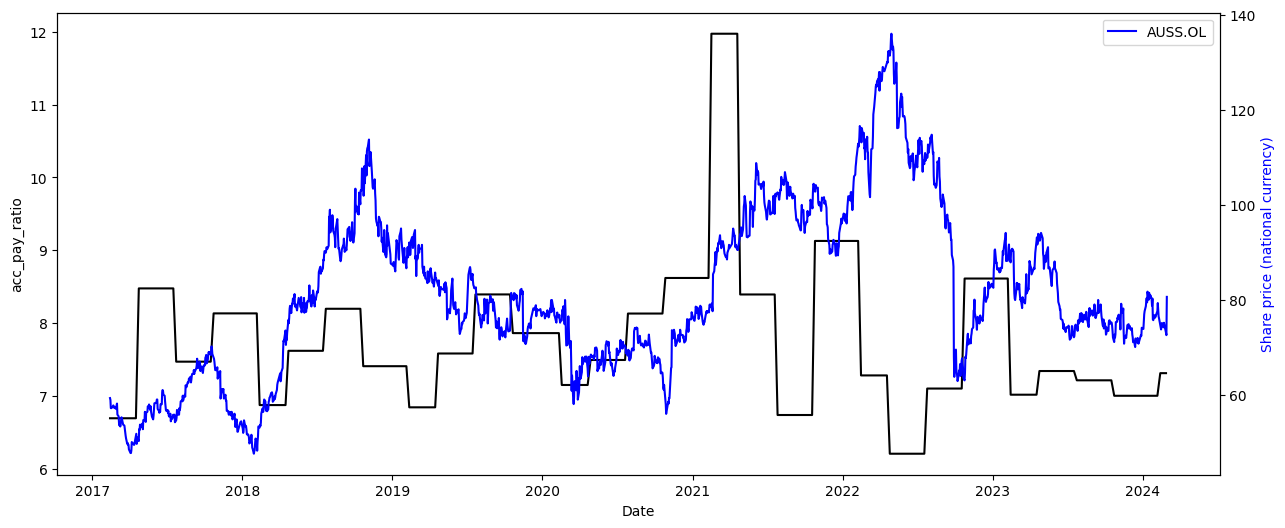

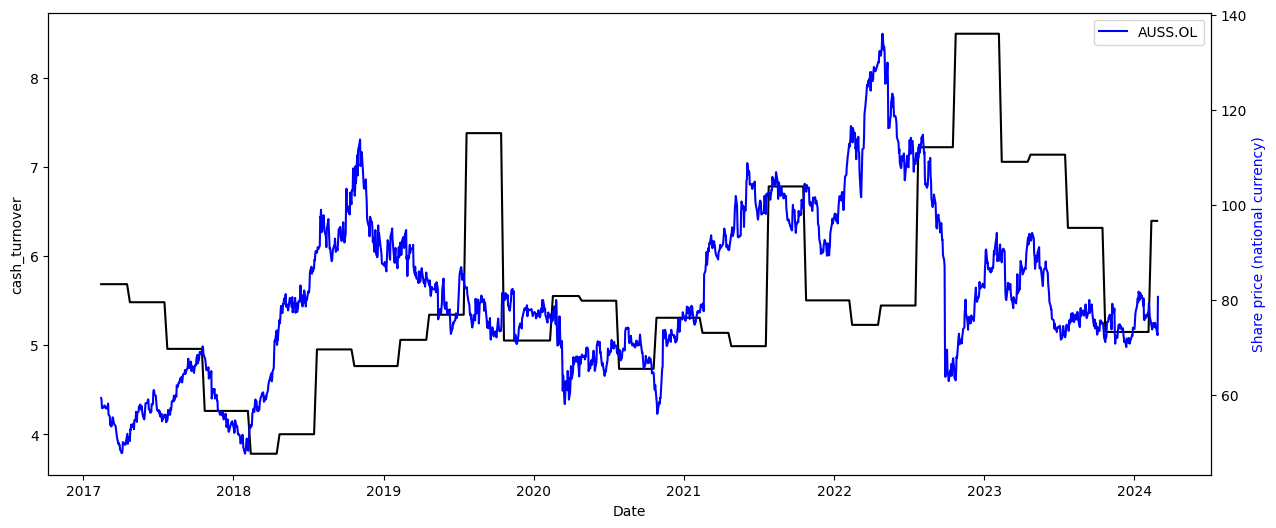

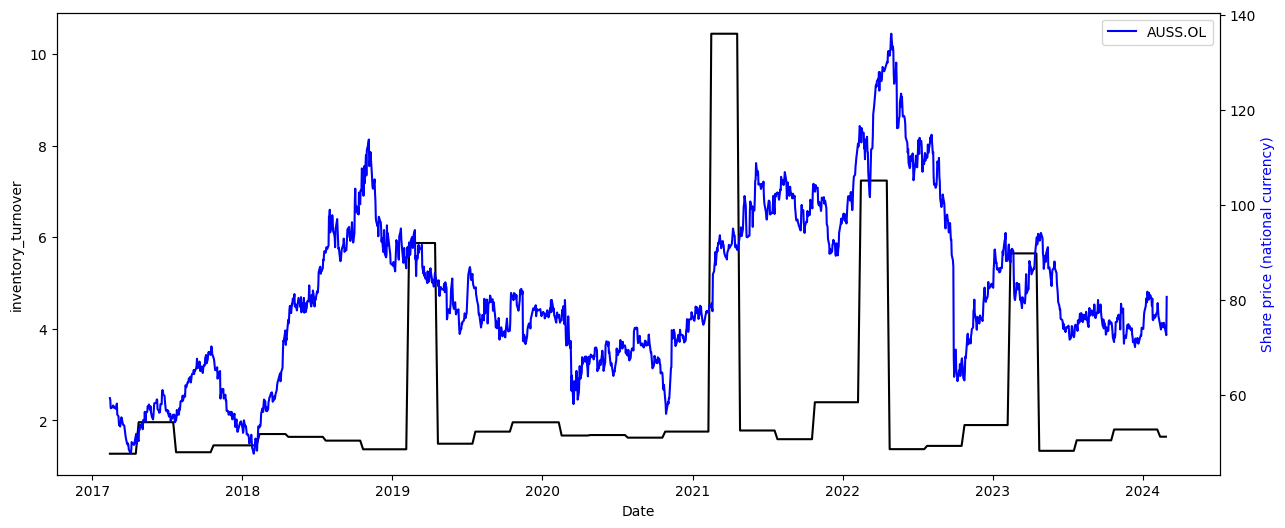

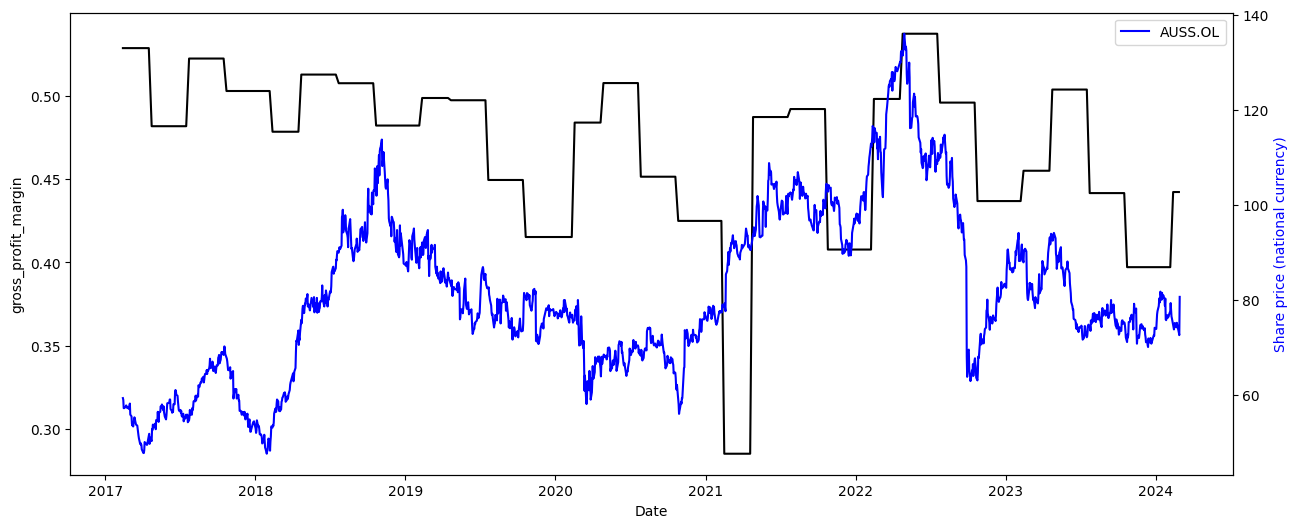

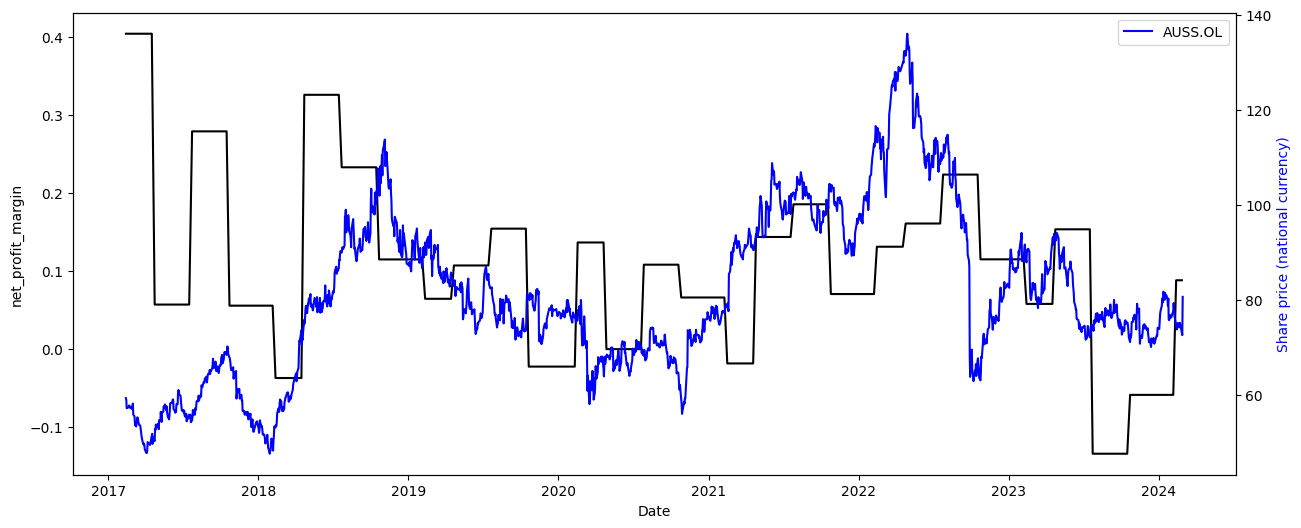

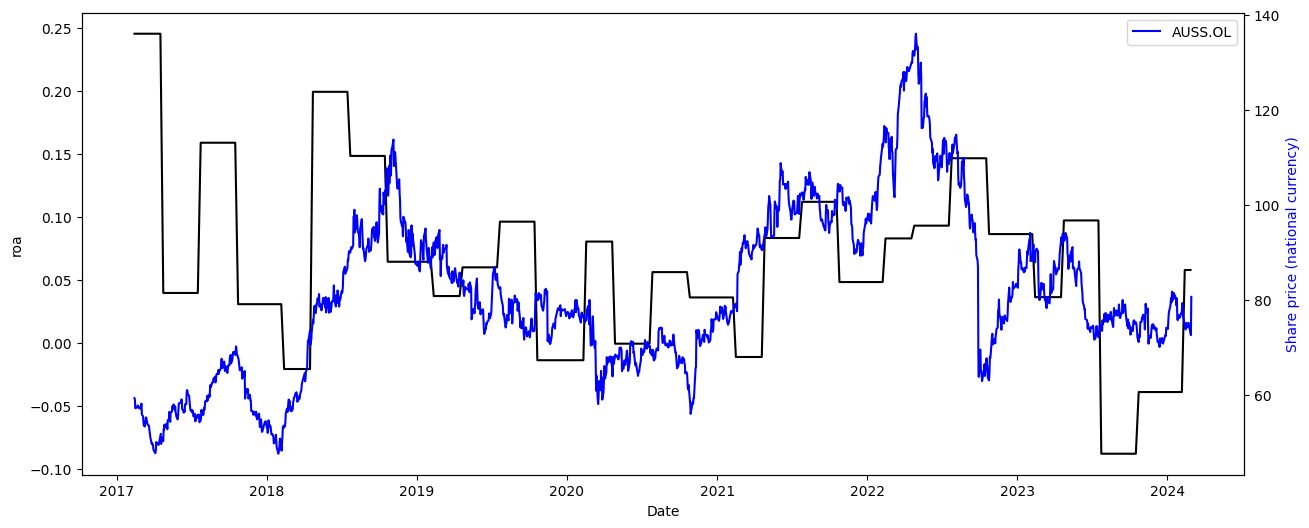

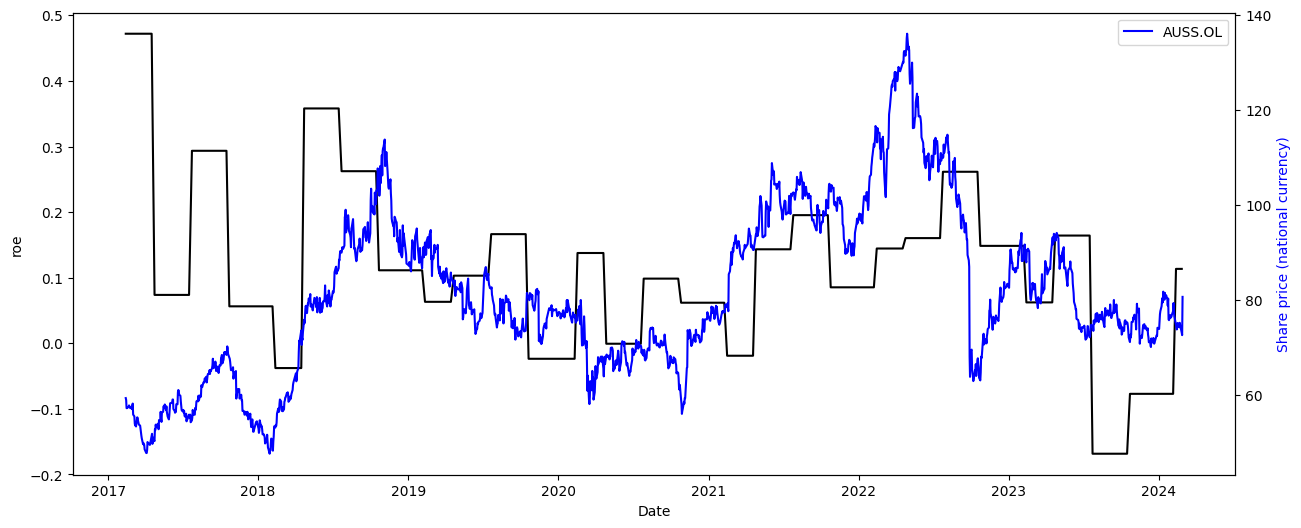

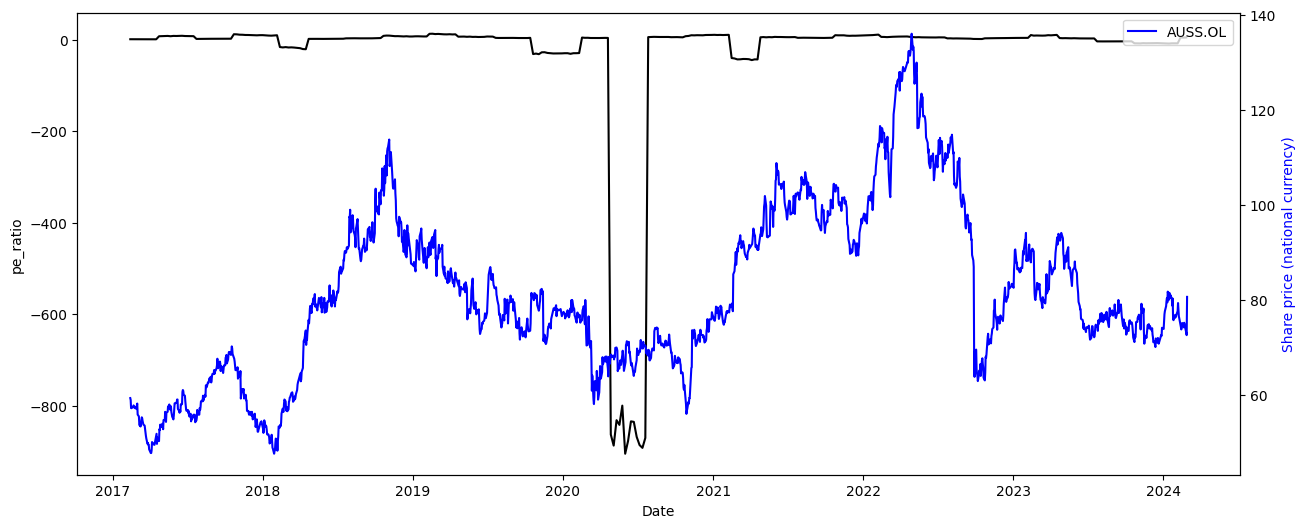

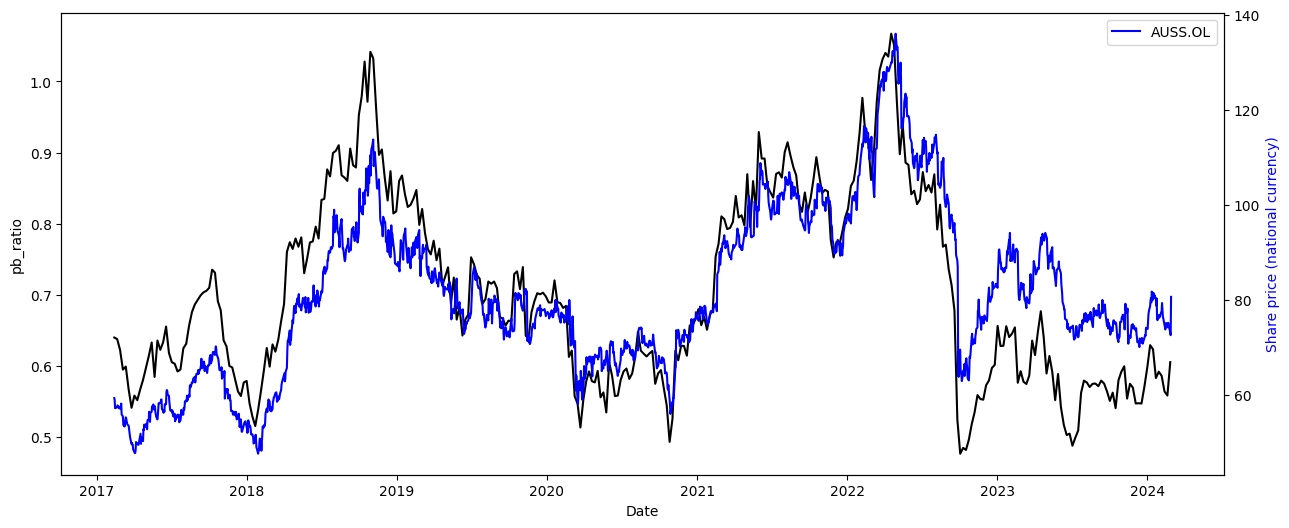

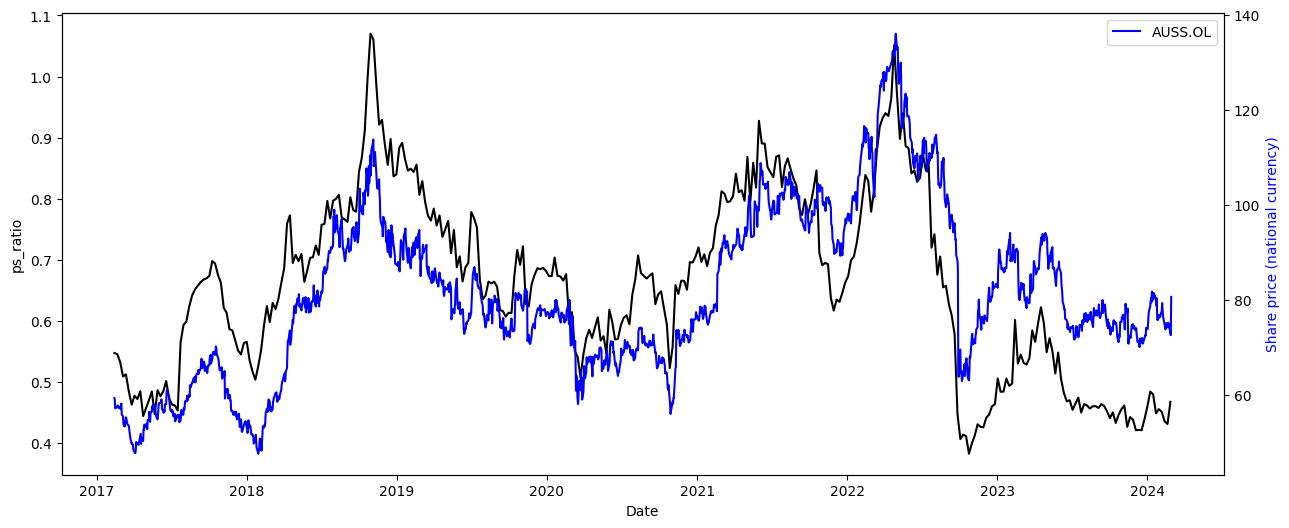

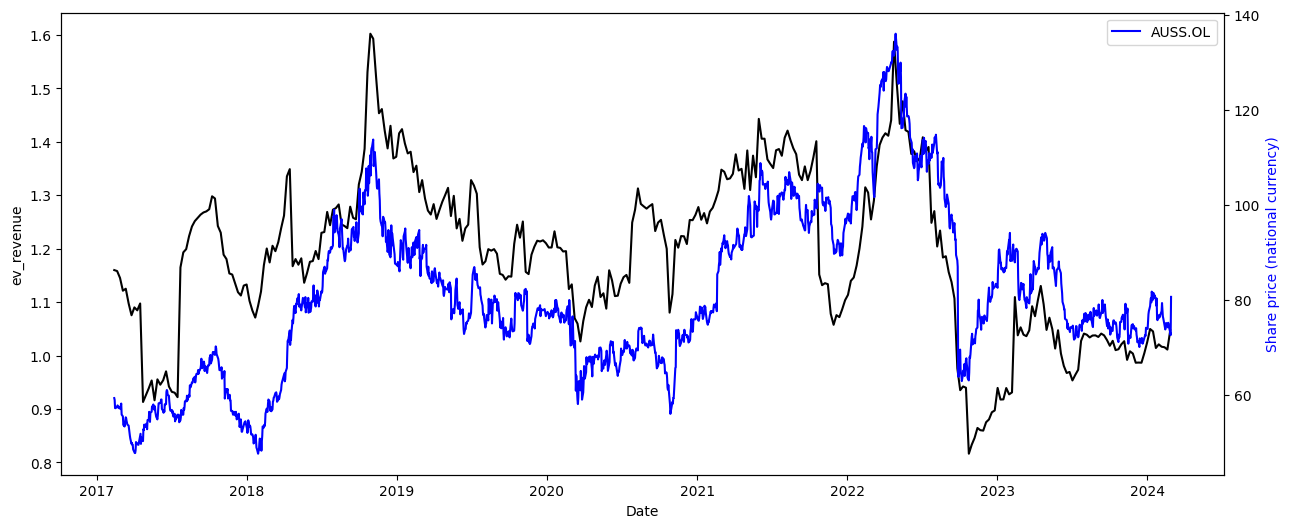

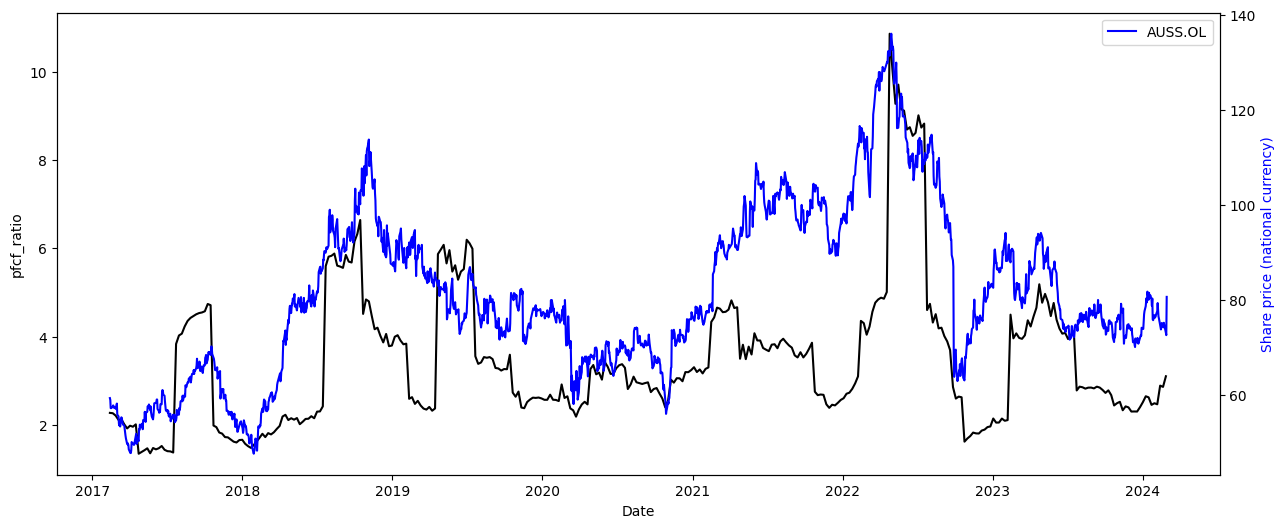

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

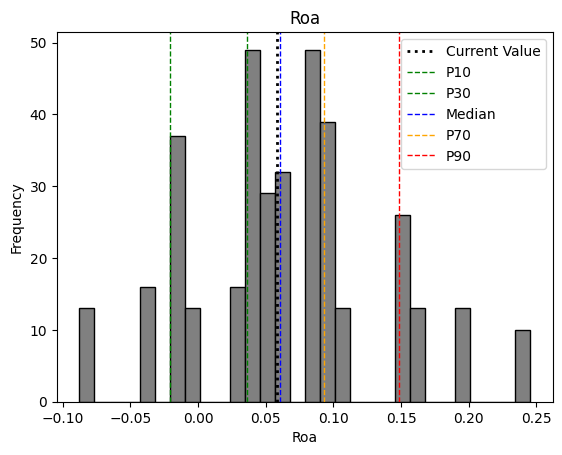

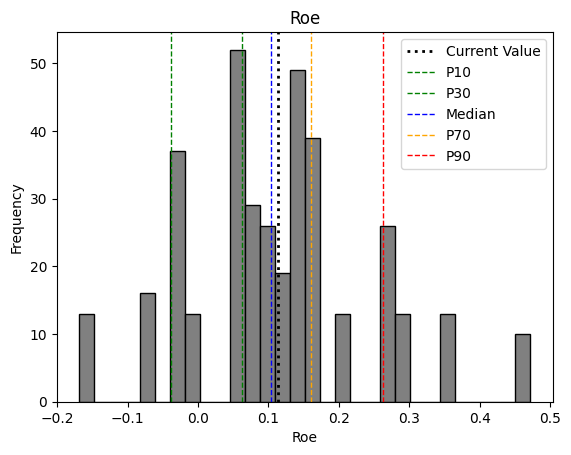

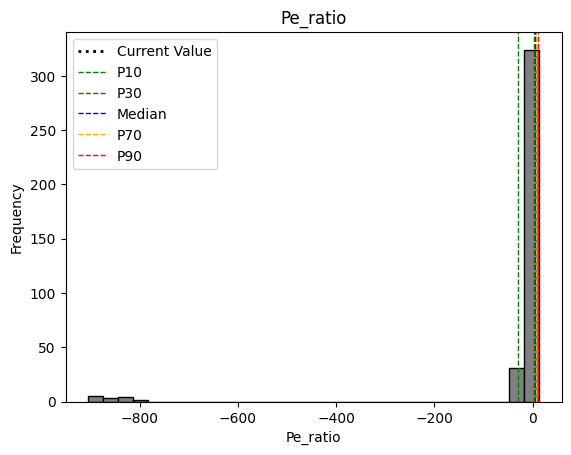

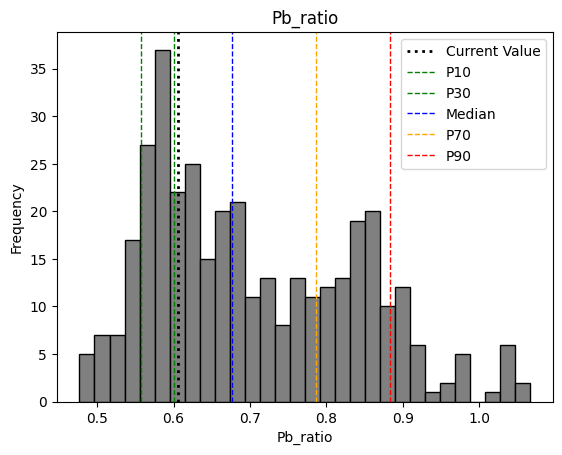

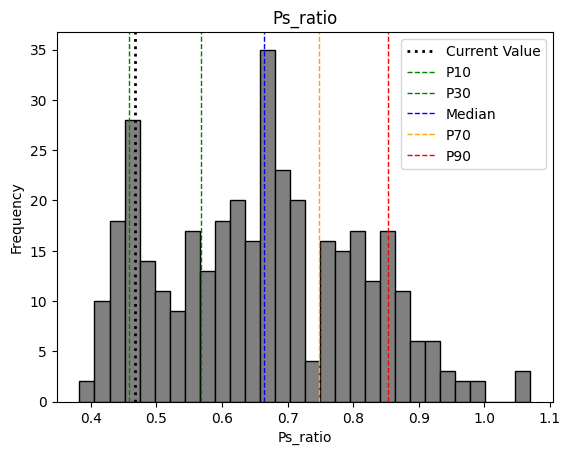

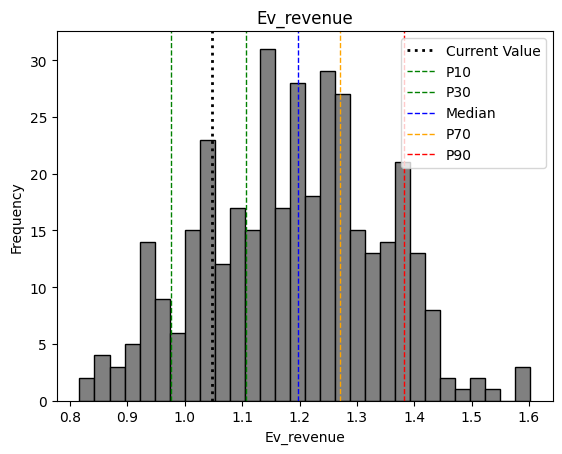

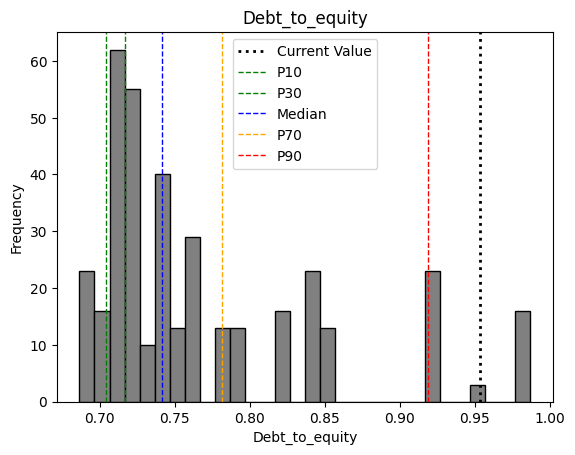

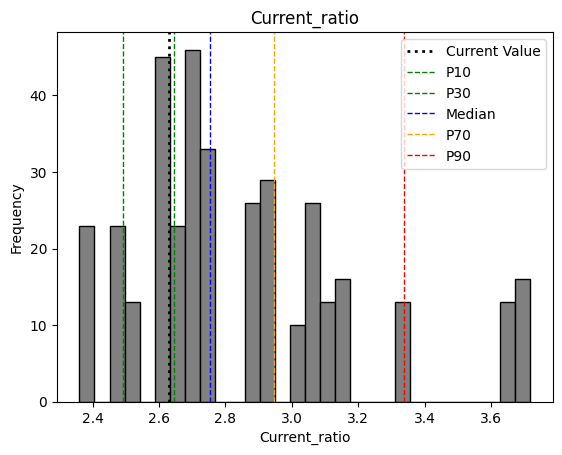

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.998775,0.205859,0.266762,0.203932,0.158299,-0.148490,0.135357
roe,0.998775,1.000000,0.196750,0.253058,0.191526,0.152665,-0.125653,0.139492
pe_ratio,0.205859,0.196750,1.000000,0.187107,0.092046,0.069733,0.138699,0.079114
pb_ratio,0.266762,0.253058,0.187107,1.000000,0.910662,0.794324,-0.309529,0.164179
ps_ratio,0.203932,0.191526,0.092046,0.910662,1.000000,0.952025,-0.491571,0.170875
ev_revenue,0.158299,0.152665,0.069733,0.794324,0.952025,1.000000,-0.359067,0.184701
debt_to_equity,-0.148490,-0.125653,0.138699,-0.309529,-0.491571,-0.359067,1.000000,0.116062
current_ratio,0.135357,0.139492,0.079114,0.164179,0.170875,0.184701,0.116062,1.000000


3 timestemos have been found!


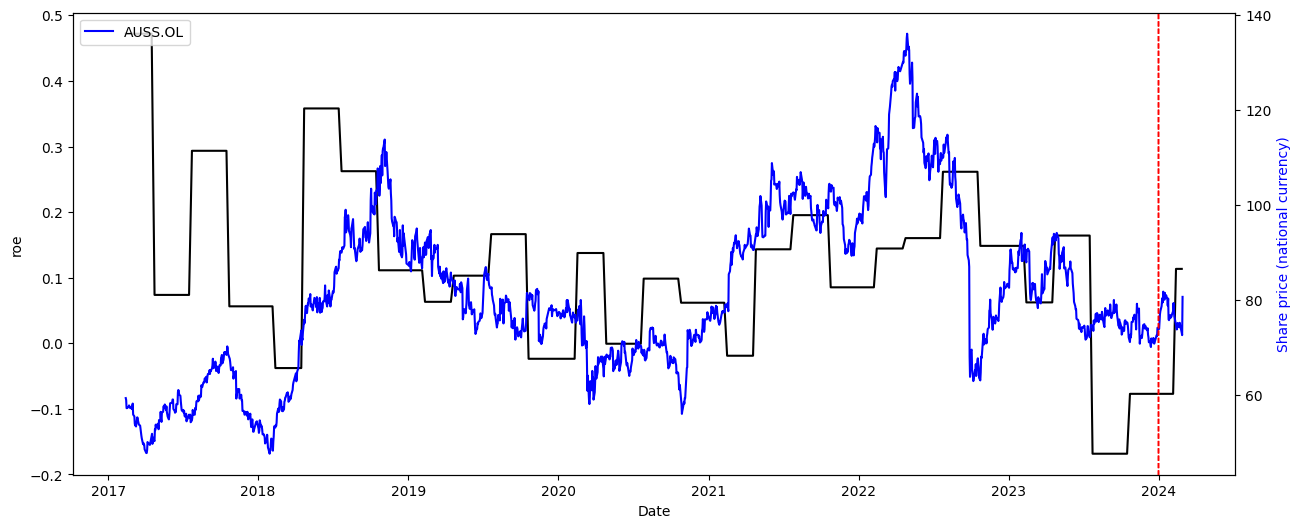

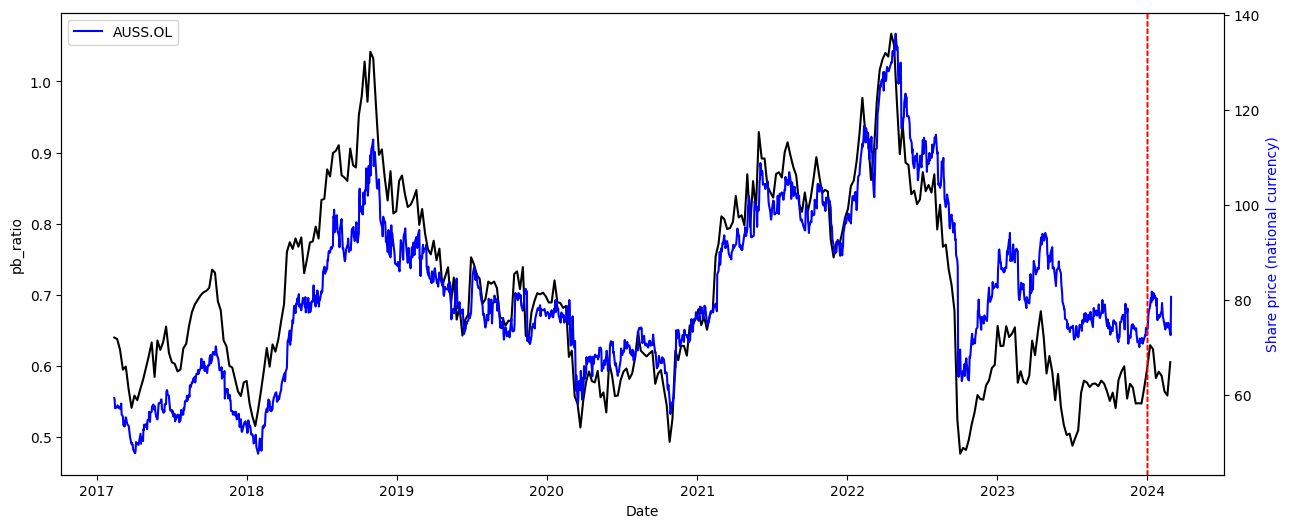

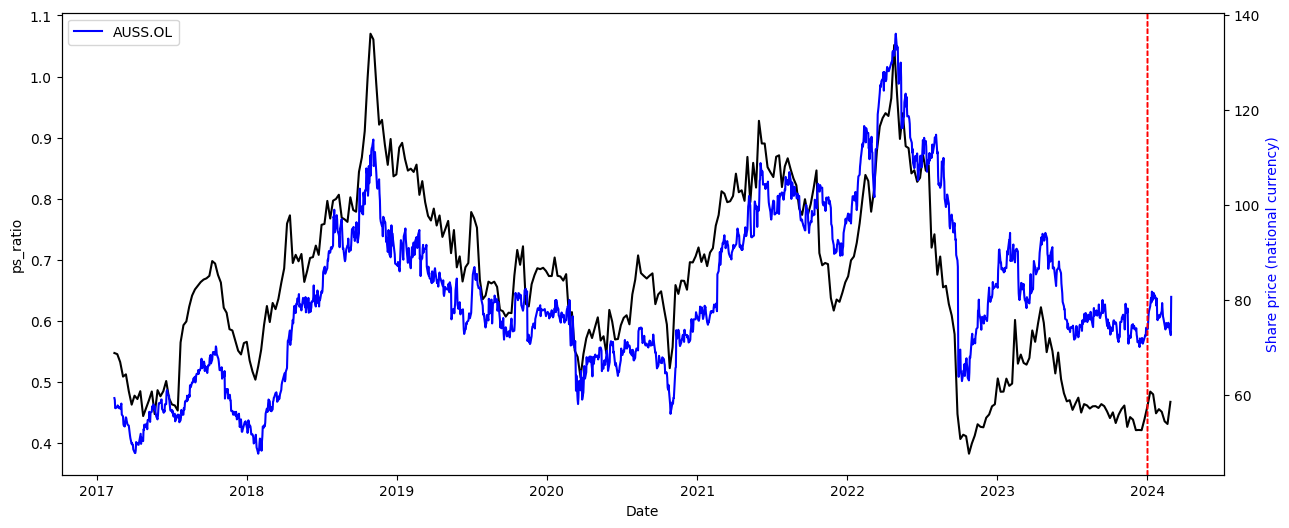

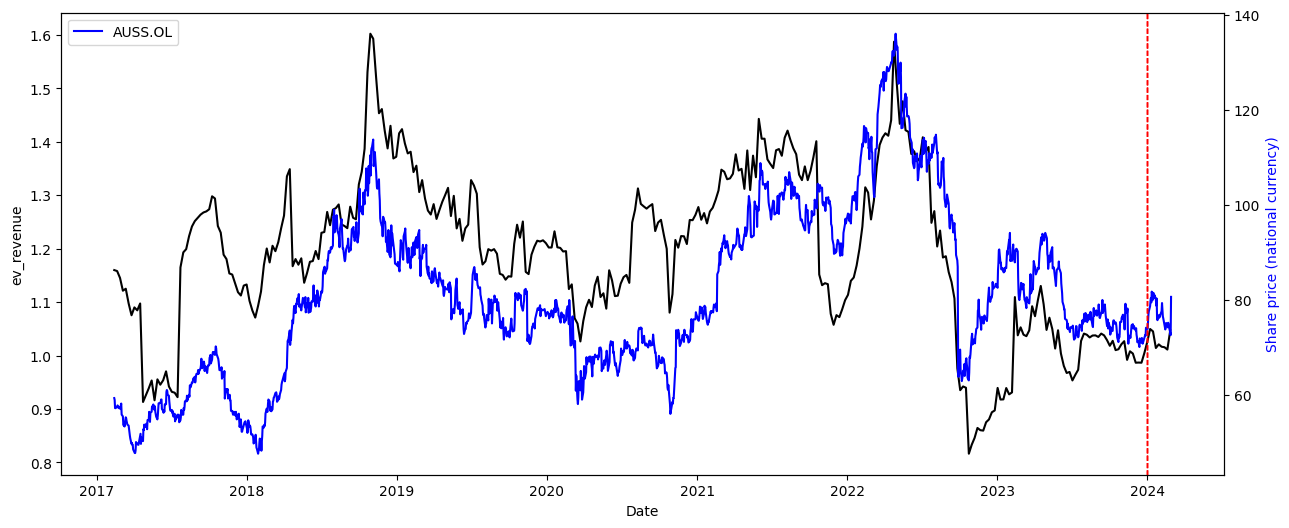

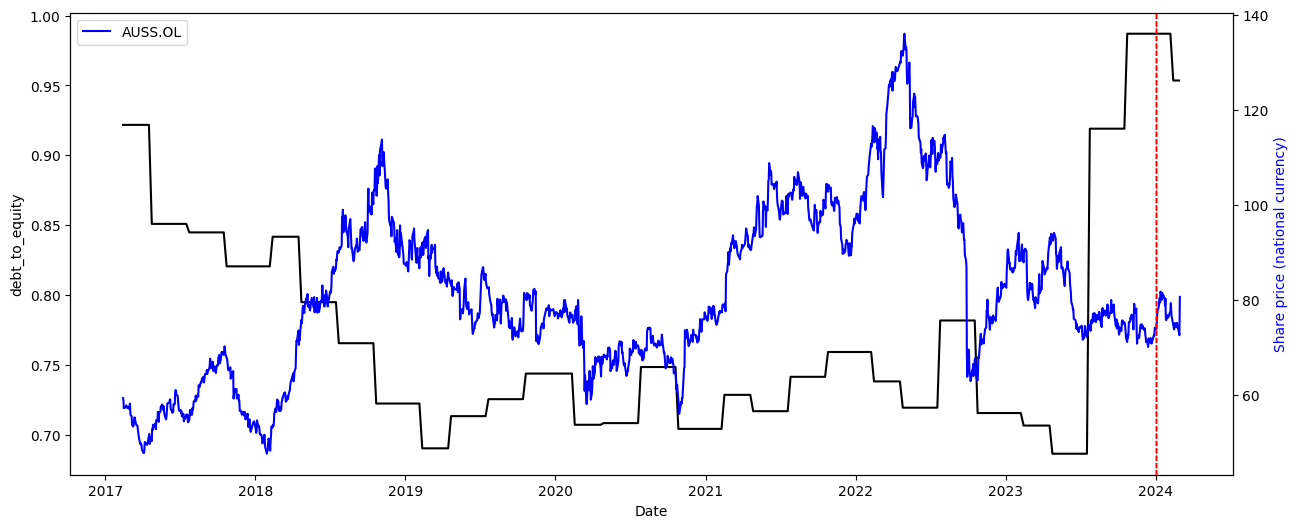

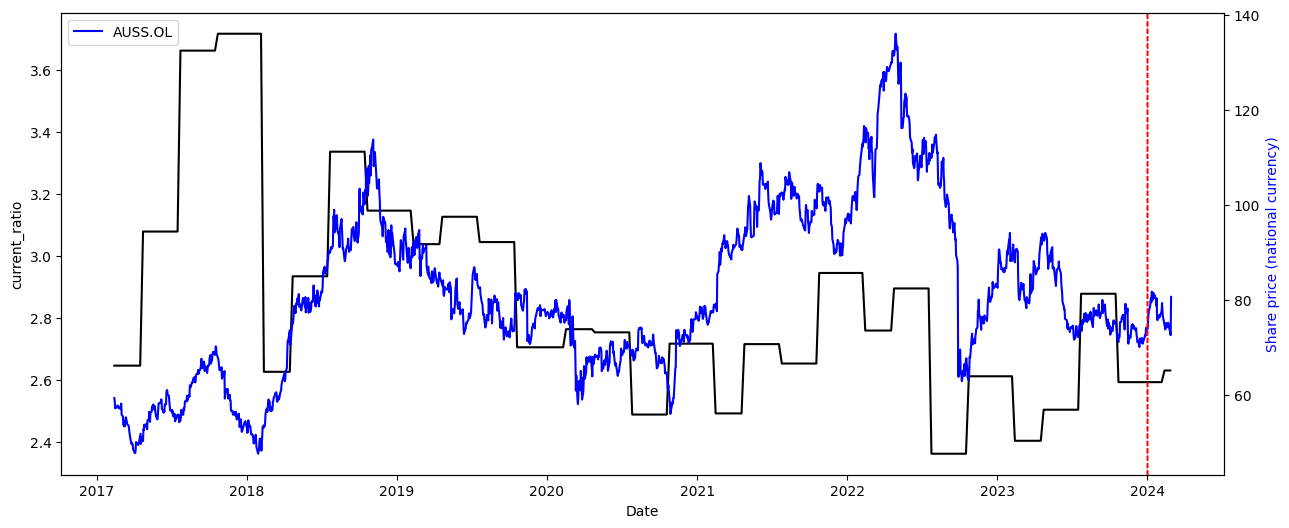

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )